In [1]:
import math
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from DataTidy import json_reader, read_a_season, read_seasons, read_all_game

# Setup step:

Train set: from 2016-2017 to 2019-2020 (Including Regular games "02" and Playoffs "03")

Test set: 2020-2021 (Including Regular games "02" and Playoffs "03")

In [2]:
if not os.path.exists("csv"):
    os.makedirs("csv")
for year in [2016, 2017, 2018, 2019]: # 2020 has been excluded to be reserved as the test set
    read_a_season("nhl_data/",year).to_csv('csv/tidy_{season}.csv'.format(season = year), sep = ',', index = False)

100%|██████████████████████████████████████| 6433/6433 [00:55<00:00, 115.97it/s]


### Test Record

In [3]:
# For test:
#df_2019020001 = json_reader("nhl_data/2019020001.json")
df_2016020001 = json_reader("nhl_data/2016020001.json")
#df_2019020001.head(10)
df_2016020001.head(10)

,game_id,event_idx,play_type,shot_type,shot_dist,game_time,goals_home,goals_away,attack_team_name,period,period_time_rem,coordinate,shooter_name,goalie_name,empty_Net,strength,rink_side,angle_net,is_goal
0,2016020001,9,Shot,Wrist Shot,13.000000,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,18:49,"{'x': -77.0, 'y': 5.0}",Mitchell Marner,Craig Anderson,None,None,right,-22.619865,0
1,2016020001,16,Shot,Wrist Shot,13.341664,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,17:07,"{'x': 86.0, 'y': 13.0}",Chris Kelly,Frederik Andersen,None,None,left,77.005383,0
2,2016020001,23,Shot,Wrist Shot,76.157731,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,15:59,"{'x': 23.0, 'y': -38.0}",Cody Ceci,Frederik Andersen,None,None,left,-29.931512,0
3,2016020001,25,Shot,Slap Shot,57.974132,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,15:14,"{'x': 33.0, 'y': -15.0}",Erik Karlsson,Frederik Andersen,None,None,left,-14.995079,0
4,2016020001,38,Shot,Wrist Shot,61.717096,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,13:14,"{'x': -34.0, 'y': 28.0}",Martin Marincin,Craig Anderson,None,None,right,-26.980231,0
5,2016020001,40,Shot,Wrist Shot,58.523500,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,12:30,"{'x': -33.0, 'y': -17.0}",Mitchell Marner,Craig Anderson,None,None,right,16.886791,0
6,2016020001,43,Goal,Wrist Shot,19.026298,2016-10-12T23:00:00Z,0,1,Toronto Maple Leafs,1,11:39,"{'x': -70.0, 'y': 1.0}",Auston Matthews,Craig Anderson,False,EVEN,right,-3.012788,1
7,2016020001,45,Shot,Wrist Shot,56.850682,2016-10-12T23:00:00Z,0,1,Toronto Maple Leafs,1,11:31,"{'x': -45.0, 'y': -36.0}",Matt Martin,Craig Anderson,None,None,right,39.289407,0
8,2016020001,48,Shot,Slap Shot,58.821765,2016-10-12T23:00:00Z,0,1,Ottawa Senators,1,11:00,"{'x': 33.0, 'y': -18.0}",Erik Karlsson,Frederik Andersen,None,None,left,-17.818889,0
9,2016020001,59,Shot,Wrist Shot,58.523500,2016-10-12T23:00:00Z,0,1,Ottawa Senators,1,09:44,"{'x': 34.0, 'y': 20.0}",Erik Karlsson,Frederik Andersen,None,None,left,19.983107,0


### Consolidating and Sorting CSV Files into a Unified DataFrame

In [4]:
directory = 'csv'

# Get a list of csv file names within the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Sort the list of csv files
csv_files.sort()

# List to hold your DataFrames
dataframes_list = []

# Loop over the sorted list of csv files with tqdm for progress indication
for filename in tqdm(csv_files, desc="Loading files", unit="file"):
    file_path = os.path.join(directory, filename)
    df = pd.read_csv(file_path)
    dataframes_list.append(df)

# Concatenate all the DataFrames in the list into a single DataFrame
train_df = pd.concat(dataframes_list, ignore_index=True)

# Sort the DataFrame first by 'game_id' and then by 'event_idx'
train_df = train_df.sort_values(by=['game_id', 'event_idx'])

# Reset the index of the sorted DataFrame
train_df = train_df.reset_index(drop=True)

Loading files: 100%|████████████████████████████| 4/4 [00:00<00:00,  4.38file/s]


In [5]:
# Display the resulting DataFrame
train_df.head(10)

,game_id,event_idx,play_type,shot_type,shot_dist,game_time,goals_home,goals_away,attack_team_name,period,period_time_rem,coordinate,shooter_name,goalie_name,empty_Net,strength,rink_side,angle_net,is_goal
0,2016020001,9,Shot,Wrist Shot,13.000000,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,18:49,"{'x': -77.0, 'y': 5.0}",Mitchell Marner,Craig Anderson,NaN,NaN,right,-22.619865,0
1,2016020001,16,Shot,Wrist Shot,13.341664,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,17:07,"{'x': 86.0, 'y': 13.0}",Chris Kelly,Frederik Andersen,NaN,NaN,left,77.005383,0
2,2016020001,23,Shot,Wrist Shot,76.157731,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,15:59,"{'x': 23.0, 'y': -38.0}",Cody Ceci,Frederik Andersen,NaN,NaN,left,-29.931512,0
3,2016020001,25,Shot,Slap Shot,57.974132,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,15:14,"{'x': 33.0, 'y': -15.0}",Erik Karlsson,Frederik Andersen,NaN,NaN,left,-14.995079,0
4,2016020001,38,Shot,Wrist Shot,61.717096,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,13:14,"{'x': -34.0, 'y': 28.0}",Martin Marincin,Craig Anderson,NaN,NaN,right,-26.980231,0
5,2016020001,40,Shot,Wrist Shot,58.523500,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,12:30,"{'x': -33.0, 'y': -17.0}",Mitchell Marner,Craig Anderson,NaN,NaN,right,16.886791,0
6,2016020001,43,Goal,Wrist Shot,19.026298,2016-10-12T23:00:00Z,0,1,Toronto Maple Leafs,1,11:39,"{'x': -70.0, 'y': 1.0}",Auston Matthews,Craig Anderson,False,EVEN,right,-3.012788,1
7,2016020001,45,Shot,Wrist Shot,56.850682,2016-10-12T23:00:00Z,0,1,Toronto Maple Leafs,1,11:31,"{'x': -45.0, 'y': -36.0}",Matt Martin,Craig Anderson,NaN,NaN,right,39.289407,0
8,2016020001,48,Shot,Slap Shot,58.821765,2016-10-12T23:00:00Z,0,1,Ottawa Senators,1,11:00,"{'x': 33.0, 'y': -18.0}",Erik Karlsson,Frederik Andersen,NaN,NaN,left,-17.818889,0
9,2016020001,59,Shot,Wrist Shot,58.523500,2016-10-12T23:00:00Z,0,1,Ottawa Senators,1,09:44,"{'x': 34.0, 'y': 20.0}",Erik Karlsson,Frederik Andersen,NaN,NaN,left,19.983107,0


### Segmenting DataFrame into Goals and No-Goals

In [6]:
# DataFrame for No Goals:
df_no_goals = train_df[train_df['is_goal'] == 0]
# DataFrame for Goals:
df_goals = train_df[train_df['is_goal'] == 1]

In [7]:
# View of the DataFrame for No Goals:
df_no_goals.head(5)
#df_no_goals.tail(5)

,game_id,event_idx,play_type,shot_type,shot_dist,game_time,goals_home,goals_away,attack_team_name,period,period_time_rem,coordinate,shooter_name,goalie_name,empty_Net,strength,rink_side,angle_net,is_goal
0,2016020001,9,Shot,Wrist Shot,13.000000,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,18:49,"{'x': -77.0, 'y': 5.0}",Mitchell Marner,Craig Anderson,NaN,NaN,right,-22.619865,0
1,2016020001,16,Shot,Wrist Shot,13.341664,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,17:07,"{'x': 86.0, 'y': 13.0}",Chris Kelly,Frederik Andersen,NaN,NaN,left,77.005383,0
2,2016020001,23,Shot,Wrist Shot,76.157731,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,15:59,"{'x': 23.0, 'y': -38.0}",Cody Ceci,Frederik Andersen,NaN,NaN,left,-29.931512,0
3,2016020001,25,Shot,Slap Shot,57.974132,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,15:14,"{'x': 33.0, 'y': -15.0}",Erik Karlsson,Frederik Andersen,NaN,NaN,left,-14.995079,0
4,2016020001,38,Shot,Wrist Shot,61.717096,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,13:14,"{'x': -34.0, 'y': 28.0}",Martin Marincin,Craig Anderson,NaN,NaN,right,-26.980231,0


In [8]:
# View of the DataFrame for Goals:
df_goals.head(5)
#df_goals.tail(5)

,game_id,event_idx,play_type,shot_type,shot_dist,game_time,goals_home,goals_away,attack_team_name,period,period_time_rem,coordinate,shooter_name,goalie_name,empty_Net,strength,rink_side,angle_net,is_goal
6,2016020001,43,Goal,Wrist Shot,19.026298,2016-10-12T23:00:00Z,0,1,Toronto Maple Leafs,1,11:39,"{'x': -70.0, 'y': 1.0}",Auston Matthews,Craig Anderson,False,EVEN,right,-3.012788,1
11,2016020001,61,Goal,Backhand,7.615773,2016-10-12T23:00:00Z,1,1,Ottawa Senators,1,09:34,"{'x': 82.0, 'y': 3.0}",Bobby Ryan,Frederik Andersen,False,EVEN,left,23.198591,1
14,2016020001,71,Goal,Slap Shot,55.009090,2016-10-12T23:00:00Z,2,1,Ottawa Senators,1,07:11,"{'x': 34.0, 'y': -1.0}",Erik Karlsson,Frederik Andersen,False,EVEN,left,-1.041627,1
15,2016020001,80,Goal,Snap Shot,30.870698,2016-10-12T23:00:00Z,2,2,Toronto Maple Leafs,1,05:42,"{'x': -76.0, 'y': -28.0}",Auston Matthews,Craig Anderson,False,EVEN,right,65.095231,1
24,2016020001,132,Goal,Wrist Shot,19.104973,2016-10-12T23:00:00Z,2,3,Toronto Maple Leafs,2,18:35,"{'x': 76.0, 'y': -14.0}",Auston Matthews,Craig Anderson,False,EVEN,left,-47.121096,1


# Question 1:

Using your training dataset create a tidied dataset for each SHOT/GOAL event, with the following columns (you can name them however you want):

- `Distance from net`: (shot_dist)
- `Angle from net`: (angle_net)
- `Is goal` (0 or 1): (is_goal)
- `Empty Net` (0 or 1; you can assume NaNs are 0): (empty_Net)

You can approximate the net as a single point (i.e., you don’t need to account for the width of the net when computing the distance or angle). You should be able to create this easily using the functionality you implemented for tidying data in Milestone 1, as you will only need the (x, y) coordinates for each shot/goal event. Create and include the following figures in your blog post and briefly discuss your observations (a few sentences):

- A histogram of shot counts (goals and no-goals separated), binned by distance
- A histogram of shot counts (goals and no-goals separated), binned by angle
- A 2D histogram where one axis is the distance and the other is the angle. You do not need to separate goals and no-goals.
  - **Hint**: check out jointplots.

As always, make sure all of your axes are labeled correctly, and you make the appropriate choice of axis scale.



### Question 1.1 (Histograms of shot counts (goals and no-goals separated), binned by distance)

In [9]:
# Function to Create and Save Histogram
def create_histogram(data, file_name, title, edge_color):
    # Create figure
    fig, ax = plt.subplots(figsize = (10, 5))
    
    # Calculate bins
    num_bins = math.ceil((data.max() - data.min()) / 4)
    bins = np.arange(0, data.max() + 20, 20)  # Ensure the range covers the max value
    
    # Create histogram
    ax.hist(data, bins = num_bins, color = 'purple', edgecolor = edge_color)
    
    # Set grid
    ax.grid(axis = 'y', color = 'gray', linestyle = '-', linewidth = 0.5)
    
    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel('Net Distance')
    ax.set_ylabel(title)

    # Set custom ticks for the x-axis
    ax.set_xticks(bins)
    
    # Save the figure
    fig.savefig(file_name)
    plt.show()  # Show the plot after saving it

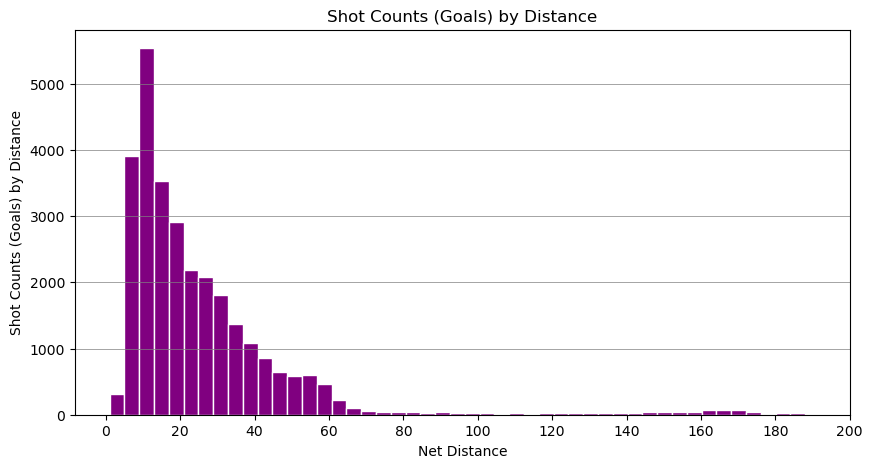

In [10]:
# Plot Histogram for Goals
create_histogram(
    df_goals['shot_dist'], 
    'FeatureEngineering1_Q2_1.png', 
    'Shot Counts (Goals) by Distance', 
    'white'
)

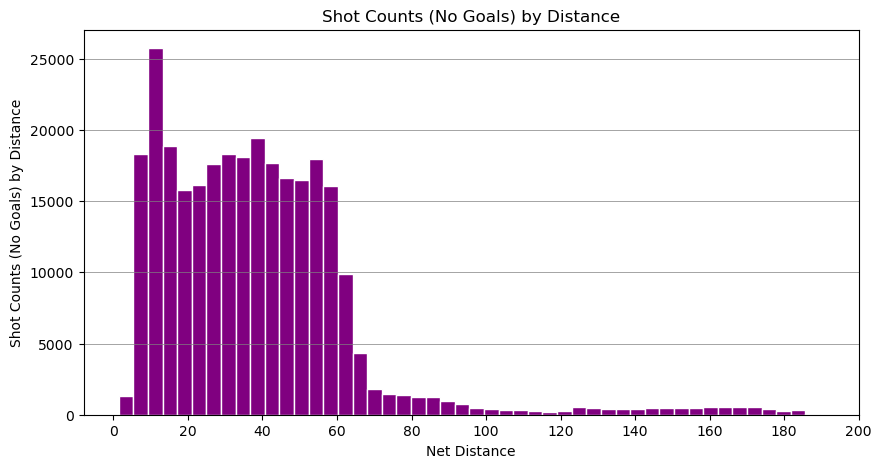

In [11]:
# Plot Histogram for No Goals
create_histogram(
    df_no_goals['shot_dist'],
    'FeatureEngineering1_Q2_2.png',
    'Shot Counts (No Goals) by Distance',
    'white'
)

### Question 1.2 (Histograms of shot counts (goals and no-goals separated), binned by angle)

In [12]:
# Function to plot histogram
def plot_histogram(data, filename, title, xlabel, ylabel, color, edgecolor):
    # Calculate the number of bins
    bins = math.ceil((data.max() - data.min()) / 4)
    
    # Create figure and plot histogram
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.hist(data, bins = bins, color = color, edgecolor = edgecolor)
    
    # Set grid, labels, and title
    ax.grid(axis = 'y', color = 'gray', linestyle = '-', linewidth = 0.5)
    ax.set(title = title, xlabel = xlabel, ylabel = ylabel)
    
    # Customize ticks
    ax.set_xticks(np.arange(-90, 120, 30))
    
    # Show and save the plot
    plt.show()
    fig.savefig(filename)

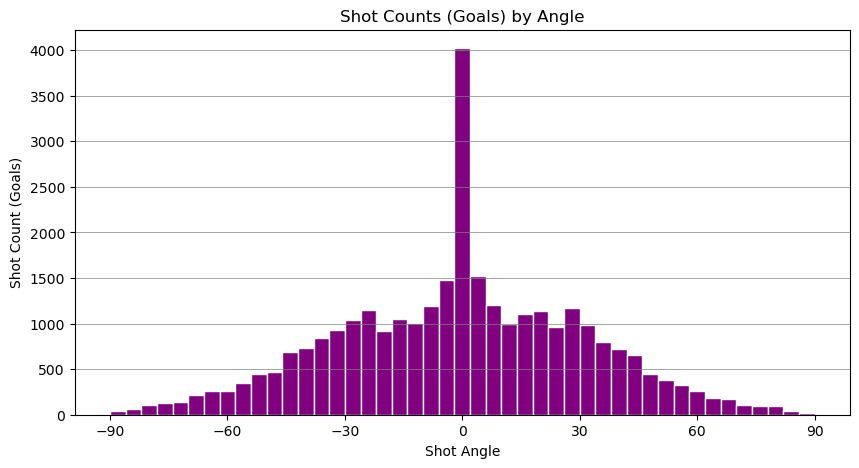

In [13]:
# Plot Histogram for Goals
plot_histogram(
    df_goals['angle_net'],
    'FeatureEngineering1_Q2_3.png',
    'Shot Counts (Goals) by Angle',
    'Shot Angle',
    'Shot Count (Goals)',
    'purple',
    'white'
)

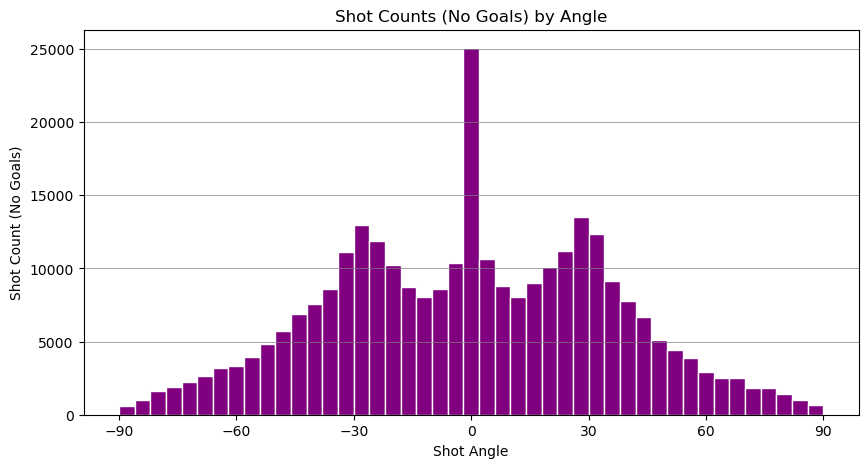

In [14]:
# Plot Histogram for No Goals
plot_histogram(
    df_no_goals['angle_net'],
    'FeatureEngineering1_Q2_4.png',
    'Shot Counts (No Goals) by Angle',
    'Shot Angle',
    'Shot Count (No Goals)',
    'purple',
    'white'
)

### Question 1.3 (2D histogram where one axis is the distance and the other is the angle)

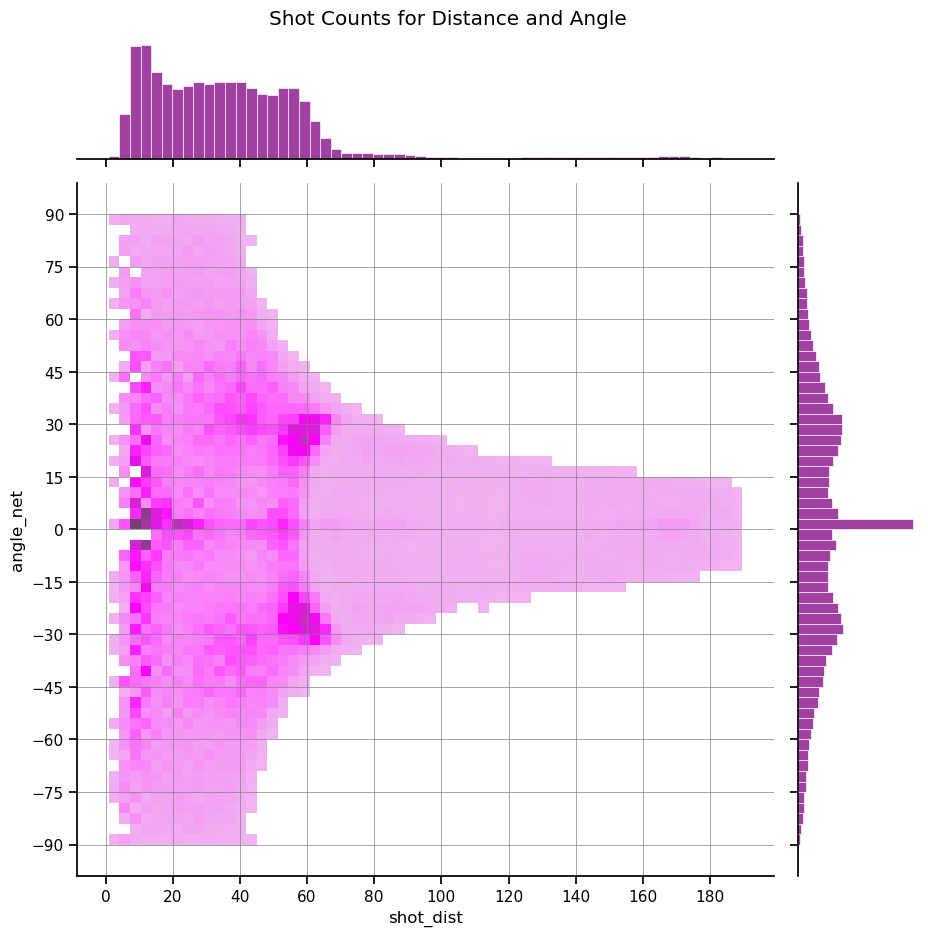

In [15]:
sns.set_palette("Paired")
sns.set_context("notebook", font_scale = 1)

# Create the jointplot with the specified parameters
joint_plot = sns.jointplot(
    data = train_df,
    x = "shot_dist",
    y = "angle_net",
    kind = "hist",
    color = 'purple',
    marginal_kws = {'bins': 60, 'edgecolor': 'white'},
    joint_kws = {'bins': 60}
)

# Set the size of the figure
joint_plot.fig.set_size_inches(10, 10)

# Set the grid properties
joint_plot.ax_joint.grid(color = 'gray', linestyle = '-', linewidth = 0.5)

# Set the title of the jointplot's figure (not the marginal axes)
joint_plot.fig.suptitle('Shot Counts for Distance and Angle')

# Adjust the title position to accommodate for the suptitle
joint_plot.fig.subplots_adjust(top = 0.95)

# Set the ticks for the y-axis
joint_plot.ax_joint.set_yticks(np.arange(-90, 105, 15))

# Set the ticks for the x-axis
joint_plot.ax_joint.set_xticks(np.arange(0, 200, 20))

# Save the figure
joint_plot.savefig("FeatureEngineering1_Q2_5.png")

The joint plot suggests that most shots are taken from moderate distances with small angles from the reference point. The decline in shot counts as distance increases or as the angle becomes more extreme is likely due to the increased difficulty of making a shot under those conditions.

# Question 2:

Now, create two more figures relating the goal rate, i.e., `#goals / (#no_goals + #goals)`, to the distance, and goal rate to the angle of the shot. Include these figures in your blog post and briefly discuss your observations.


/var/folders/6j/jvpvkjtd68g2vtfwt39f5k5c0000gn/T/ipykernel_62248/2691938968.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_data = df_modified.groupby('distanceNetBins')[['shot', 'is_goal']].sum().reset_index()


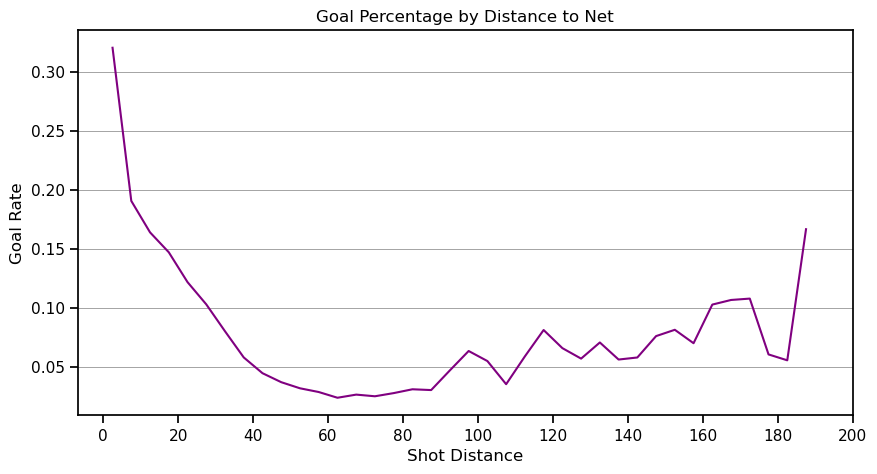

In [16]:
# Copying the DataFrame
df_modified = train_df.copy()

# Creating bins and bin_centers using np.arange
bin_edges = np.arange(0, 200, 5)
bin_centers = np.arange(2.5, 197.5, 5)

# Binning the 'shot_dist' data
df_modified['distanceNetBins'] = pd.cut(df_modified['shot_dist'], bin_edges, labels = bin_centers)

# Assigning a constant value
df_modified['shot'] = 1

# Aggregating the data - Corrected line
aggregated_data = df_modified.groupby('distanceNetBins')[['shot', 'is_goal']].sum().reset_index()

# Calculating the rate
aggregated_data['rate'] = aggregated_data['is_goal'] / aggregated_data['shot']

# Plotting the data
plot_figure = plt.figure(figsize = (10, 5))
plt.title("Goal Percentage by Distance to Net")
shot_distance_plot = sns.lineplot(x = 'distanceNetBins', y = 'rate', data = aggregated_data, linewidth = 1.5, color = 'purple')
shot_distance_plot.set(xlabel = 'Shot Distance', ylabel = 'Goal Rate')
plt.grid(axis = 'y', color = 'gray', linestyle = '-', linewidth = 0.5)
plt.xticks(np.arange(0, 220, 20))

# Saving the figure
plot_figure.savefig("FeatureEngineering1_Q2_6.png")

/var/folders/6j/jvpvkjtd68g2vtfwt39f5k5c0000gn/T/ipykernel_62248/3508473730.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df2.groupby('angleNetBins')[['shot', 'is_goal']].sum().reset_index()


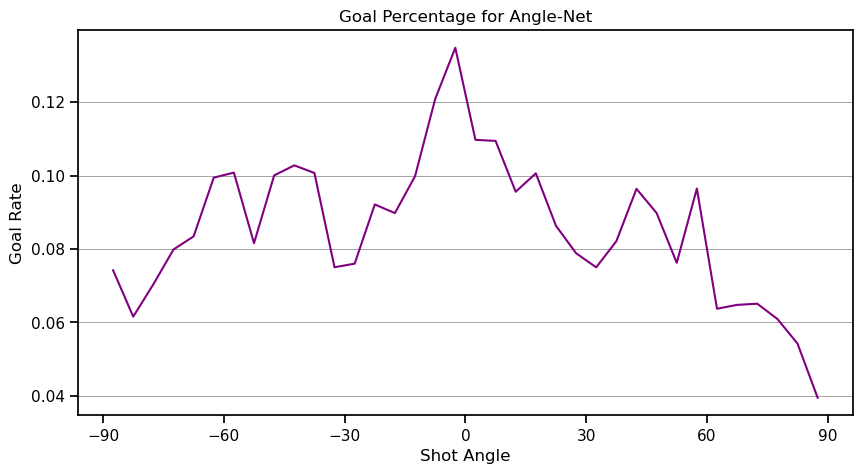

In [17]:
# Copying the dataframe and creating bins and bin centers
df2 = df.copy()
bin_edges = np.arange(-90, 95, 5)  # Include the rightmost edge
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculating bin centers directly

# Bin the data and create a 'shot' column
df2['angleNetBins'] = pd.cut(df2['angle_net'], bins = bin_edges, labels = bin_centers, include_lowest = True)
df2['shot'] = 1

# Group by the binned column and calculate the sum and rate
grouped = df2.groupby('angleNetBins')[['shot', 'is_goal']].sum().reset_index()
grouped['rate'] = grouped['is_goal'] / grouped['shot']

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x = 'angleNetBins', y = 'rate', data = grouped, ax = ax, linewidth = 1.5, color = 'purple')

# Set the plot title and labels
ax.set_title("Goal Percentage for Angle-Net")
ax.set_xlabel('Shot Angle')
ax.set_ylabel('Goal Rate')
ax.grid(axis = 'y', color = 'gray', linestyle = '-', linewidth = 0.5)

# Customize the ticks on the x-axis
ax.set_xticks(np.arange(-90, 120, 30))

# Show and save the plot
plt.show()
fig.savefig("FeatureEngineering1_Q2_7.png")

# Question 3:

Finally, let's do some quick checks to see if our data makes sense. Unfortunately, we don't have time to do automated anomaly detection, but we can use our "domain knowledge" for some quick sanity checks! The domain knowledge is that "it is incredibly rare to score a non-empty net goal on the opposing team from within your defensive zone." Knowing this, create another histogram, this time of goals only, binned by distance, and separate empty net and non-empty net events. Include this figure in your blog post and discuss your observations. Can you find any events that have incorrect features (e.g., wrong x/y coordinates)? If yes, prove that one event has incorrect features.

- **Hint**: the NHL gamecenter usually has video clips of goals for every game.

In [18]:
# Analyzing Goal Success with and without Goalies in Hockey Games
df_empty_Net = train_df[(train_df['empty_Net'] == 1) & (train_df['is_goal'] == 1)]
df_Net = train_df[(train_df['empty_Net'] == 0) & (train_df['is_goal'] == 1)]

# Calculate bin edges for the histograms
bin_width = 4
data_range_empNet = df_empty_Net['shot_dist']
data_range_Net = df_Net['shot_dist']

bin_edges_empNet = np.arange(start = min(data_range_empNet), stop = max(data_range_empNet) + bin_width, step = bin_width)
bin_edges_Net = np.arange(start = min(data_range_Net), stop = max(data_range_Net) + bin_width, step = bin_width)

# Function to plot histogram
def plot_histogram(data, title, xlabel, ylabel, bins, filename):
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.hist(data, bins = bins, edgecolor = 'white', color = 'purple')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(0, 200, 20))
    ax.grid(axis = 'y', linewidth = 0.5)
    plt.show()
    fig.savefig(filename)

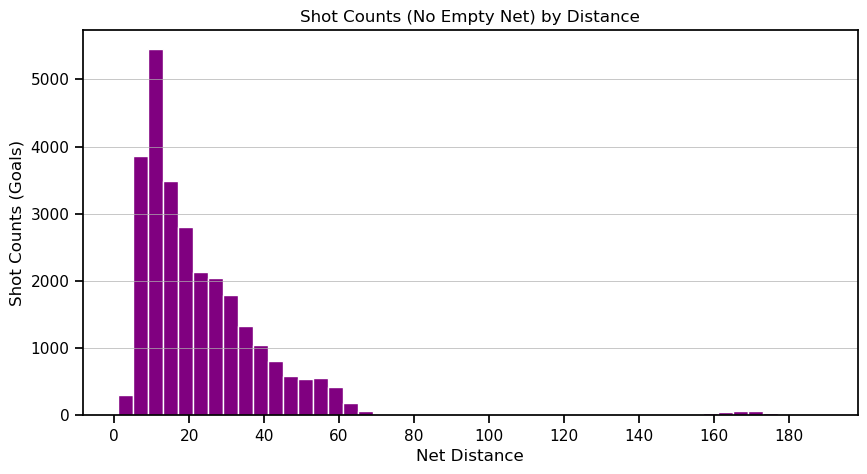

In [19]:
# Plot Histograms for No Empty Net
plot_histogram(
    data_range_Net,
    'Shot Counts (No Empty Net) by Distance',
    'Net Distance',
    'Shot Counts (Goals)',
    bin_edges_Net,
    'FeatureEngineering1_Q2_8.png'
)

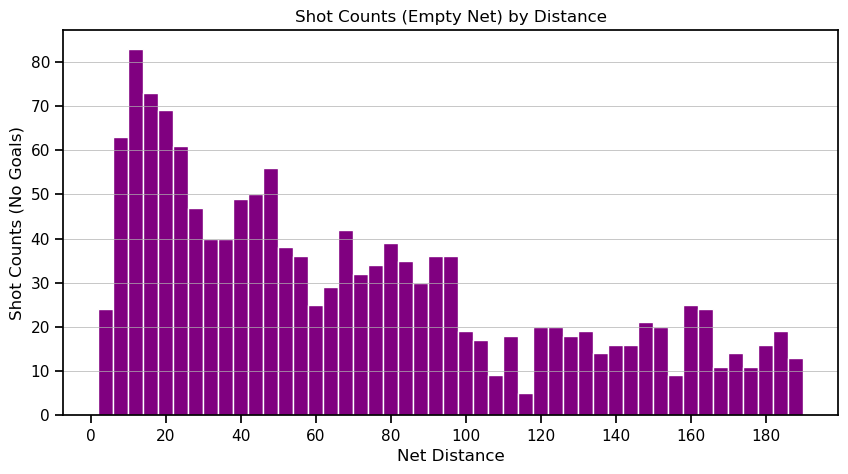

In [20]:
# Plot Histograms for Empty Net
plot_histogram(
    data_range_empNet, 
    'Shot Counts (Empty Net) by Distance',
    'Net Distance',
    'Shot Counts (No Goals)',
    bin_edges_empNet,
    'FeatureEngineering1_Q2_9.png'
)

In [21]:
#df_goals = train_df[train_df['is_goal'] == 1]
goal_anomally = df_goals[
    (df_goals['coordinate'].apply(lambda coord: abs(ast.literal_eval(coord).get('x', 0)) > 89)) &
    (df_goals['shot_dist'] > 89) &
    (df_goals['empty_Net'] == 0)
]

goal_anomally

,game_id,event_idx,play_type,shot_type,shot_dist,game_time,goals_home,goals_away,attack_team_name,period,period_time_rem,coordinate,shooter_name,goalie_name,empty_Net,strength,rink_side,angle_net,is_goal
30946,2016020510,167,Goal,Slap Shot,187.181730,2016-12-24T00:30:00Z,3,1,Florida Panthers,2,09:33,"{'x': -97.0, 'y': 21.0}",Derek MacKenzie,Jared Coreau,False,EVEN,left,6.4416,1
323229,2019030145,212,Goal,Wrist Shot,187.523332,2020-08-19T20:00:00Z,2,1,Boston Bruins,2,00:04,"{'x': 98.0, 'y': 14.0}",Patrice Bergeron,Petr Mrazek,False,PPG,right,-4.0000,1
323430,2019030154,101,Goal,Snap Shot,187.181730,2020-08-16T22:30:00Z,2,0,Chicago Blackhawks,1,06:20,"{'x': 97.0, 'y': 21.0}",Matthew Highmore,Robin Lehner,False,EVEN,right,-6.0000,1
324186,2019030176,32,Goal,Wrist Shot,184.567061,2020-08-21T02:30:00Z,2,0,Calgary Flames,1,14:22,"{'x': 94.0, 'y': 24.0}",Johnny Gaudreau,Anton Khudobin,False,PPG,right,-7.0000,1
324531,2019030185,115,Goal,Backhand,180.136060,2020-08-20T02:30:00Z,2,1,St. Louis Blues,1,00:29,"{'x': -91.0, 'y': -7.0}",Ryan O'Reilly,Jacob Markstrom,False,EVEN,left,-2.0000,1
